In [75]:
# ?kernel_name=py374

In [76]:
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import cv2

np.random.seed(101)
%matplotlib inline

### 1. 이미지 전처리

In [77]:
labels = []
for folder in glob.glob('./data/*') :
    label = folder.split('/')[-1]
    # print(label)
    labels.append(label)

In [78]:
np.array(labels)

array(['70', 'no_parking', 'no_parking_stop', '50', '60', '30'],
      dtype='<U15')

In [79]:
len(labels)

6

In [80]:
N_CLASSES = len(labels)
RESIZED_IMAGE = (28, 28)

In [81]:
# 클래스별 이미지 개수
img_cnt = []
dir_url = './data/'
for label in labels :
    # print(dir_url + label + '/*.jpg')
    # print(glob.glob(dir_url + label + '/*.jpg'))
    cnt = 0
    for file in glob.glob(dir_url + label + '/*.jpg') :
        # print(file)
        cnt += 1
    img_cnt.append(cnt)

In [82]:
np.array(img_cnt)

array([660, 189, 304, 750, 480, 730])

In [83]:
labels_cnt = {}
for label, cnt in zip(labels, img_cnt) :
    # print(label, cnt)
    labels_cnt[label] = cnt

In [84]:
labels_cnt

{'70': 660,
 'no_parking': 189,
 'no_parking_stop': 304,
 '50': 750,
 '60': 480,
 '30': 730}

In [85]:
LABELS = {}
for label, i in zip(labels, range(0, N_CLASSES)) :
    # print(i, label)
    LABELS[label] = i

In [86]:
Dataset = namedtuple('Dataset', ['X', 'y'])
print(Dataset)

<class '__main__.Dataset'>


In [87]:
# 텐서플로우에 맞는 이미지 텐서 포맷
# 차원 확장
def to_tf_format(imgs) :
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis = 0).astype(np.float32)

In [88]:
# 한 경로에 주어진 모든 이미지를 읽어서
# 그 이미지를 미리 정의한 형상으로 크기 재조정
# 회색조로 변환
# 레이블을 원 핫 인코딩

def read_dataset(root_path, labels_arr, resize_to) :
    images = []
    labels = []
    
    for label_name in labels_arr :
        # 'data/no_twowheel/''
        full_path = root_path + '/' + label_name + '/'
        
        for img in glob.glob(full_path + '*.jpg') :
            # print(img)
            image = cv2.imread(img).astype(np.float32)
            # 회색조로 변환
            image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)[:, :, 0]
            
            # 크기 조정
            if resize_to :
                image = cv2.resize(image, resize_to)
            
            # 라벨
            label = np.zeros((N_CLASSES, ), dtype = np.float32)
            label[LABELS[label_name]] = 1.0
            
            images.append(image.astype(np.float32))
            labels.append(label)
            
    return Dataset(X = to_tf_format(images).astype(np.float32), y = np.matrix(labels).astype(np.float32))

In [89]:
dataset = read_dataset('data', labels, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

(3113, 28, 28, 1)
(3113, 6)


In [90]:
print(dataset.X.shape, dataset.X[0, :, :, :].shape)

(3113, 28, 28, 1) (28, 28, 1)


In [91]:
print((dataset.X[0, :, :, :].reshape(RESIZED_IMAGE)).shape)

(28, 28)


[[1. 0. 0. 0. 0. 0.]]


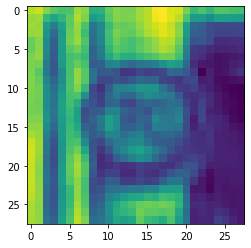

In [92]:
# 첫번째 표본
plt.imshow(dataset.X[0, :, :, :].reshape(RESIZED_IMAGE))
# 레이블
print(dataset.y[0, :])

[[0. 0. 0. 0. 0. 1.]]


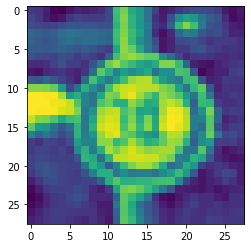

In [93]:
# 마지막 표본
plt.imshow(dataset.X[-1, :, :, :].reshape(RESIZED_IMAGE))
# 레이블
print(dataset.y[-1, :])

In [94]:
from sklearn.model_selection import train_test_split

# range(dataset.X.shape[0])
# range(0, 39209)

idx_train, idx_test = train_test_split( range(dataset.X.shape[0]), test_size = 0.25, random_state = 101 )

In [95]:
len(idx_train), len(idx_test)

(2334, 779)

In [96]:
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]

In [97]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2334, 28, 28, 1)
(779, 28, 28, 1)
(2334, 6)
(779, 6)


In [98]:
# 훈련 데이터의 미니배치 생성

def minibatcher(X, y, batch_size, shuffle) :
    assert X.shape[0] == y.shape[0]
    n_samples = X.shape[0]
    
    if shuffle :
        idx = np.random.permutation(n_samples)
    else :
        idx = list(range(n_samples))
        
    for k in range(int(np.ceil(n_samples/batch_size))) :
        from_idx = k * batch_size
        to_idx = (k+1) * batch_size
        yield X[idx[from_idx:to_idx], :, :, :], y[idx[from_idx:to_idx], :]

In [99]:
for mb in minibatcher(X_train, y_train, 1000, True) :
    print(mb[0].shape, mb[1].shape)

(1000, 28, 28, 1) (1000, 6)
(1000, 28, 28, 1) (1000, 6)
(334, 28, 28, 1) (334, 6)


### 2. 모델 구성

In [100]:
# 활성화 함수 없이 다양한 개수(인수로 제공)의 유닛을 가지고 전결합(fully connected) 계층을 만드는 것으로 시작

# in_tensors : 입력 텐서(데이터)
def fc_no_activation_layer(in_tensors, n_units) :

    # tf.get_variable(<name>, <shape>, <initializer>) : 입력된 이름의 변수를 생성하거나 반환
    # tf.get_variable()함수는 tf.Variable을 직접호출 대신 변수를 가져오거나 생성하는 데 사용
    # tf.Variable처럼 직접 값을 전달하는 대신 initializer 사용
    
    # 계층이 적절하게 중심을 잡고 분포되도록 만들기 위해
    # 계수(가중치)로는 'Xavier 초기화'
    # tf.contrib.layers.xavier_initializer()
    w = tf.get_variable('fc_W', [in_tensors.get_shape()[1], n_units], tf.float32, tf.contrib.layers.xavier_initializer())
    
    # 편향값(bias)으로는 0-초기화
    # tf.constant_initializer(value) : 제공된 값으로 모든 것을 초기화
    b = tf.get_variable('fc_B', [n_units, ], tf.float32, tf.constant_initializer(0.0))
    
    # 결과 : 입력 텐서에 가중치를 곱해서 편향값을 더한 값
    return tf.matmul(in_tensors, w) + b

In [101]:
# 활성화 함수를 사용하여 전결합 계층 만들기

def fc_layer(in_tensors, n_units) :
    return tf.nn.leaky_relu(fc_no_activation_layer(in_tensors, n_units))

In [102]:
# 입력 데이터, 커널 크기, 필터(또는 유닛) 개수를 인수로 취하는 컨볼루션 계층
# 전결합 계층에서 사용했던 것과 동일한 활성화 함수 사용
# 이 경우 출력은 leaky ReLU 활성화 함수 통과

# in_tensors : 입력 데이터
# kernel_size : 커널 크기
# n_units : 필터(유닛) 개수
def conv_layer(in_tensors, kernel_size, n_units) :
    
    w = tf.get_variable('conv_W', [kernel_size, kernel_size, in_tensors.get_shape()[3], n_units], tf.float32, tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('conv_B', [n_units, ], tf.float32, tf.constant_initializer(0.0))
        
    return tf.nn.leaky_relu(tf.nn.conv2d(in_tensors, w, [1, 1, 1, 1], 'SAME') + b) 

In [103]:
# maxpool_layer
# 여기서 윈도우 크기와 스트라이드는 모두 정사각형

def maxpool_layer(in_tensors, sampling) :
    return tf.nn.max_pool(in_tensors, [1, sampling, sampling, 1], [1, sampling, sampling, 1], 'SAME')

In [104]:
# 네트워크를 정규화하는 데 사용될 드롭아웃(dropout) 정의
# 결과를 예측할 때 사용해서는 안 되고, 네트워크를 훈련시킬 때만 사용

def dropout(in_tensors, keep_proba, is_training) :
    return tf.cond(is_training, lambda : tf.nn.dropout(in_tensors, keep_proba), lambda : in_tensors)

In [105]:
# 모델 만들기

def model(in_tensors, is_training) :
    
    # 첫 번째 계층 : 5x5 2차원 컨볼루션, 32개의 필터, 2x 맥스풀, 20% 드롭아웃
    with tf.variable_scope('l1') :
        l1 = maxpool_layer(conv_layer(in_tensors, 5, 32), 2)
        l1_out = dropout(l1, 0.8, is_training)
    
    # 두 번째 계층 : 5x5 2차원 컨볼루션, 64개의 필터, 2x 맥스풀, 20% 드롭아웃
    with tf.variable_scope('l2') :
        l2 = maxpool_layer(conv_layer(l1_out, 5, 64), 2)
        l2_out = dropout(l2, 0.8, is_training)
        
    # 평면화 계층
    with tf.variable_scope('flatten') :
        l2_out_flat = tf.layers.flatten(l2_out)
    
    # 전결합 계층
    with tf.variable_scope('l3') :
        l3 = fc_layer(l2_out_flat, 1024)
        # l3 = fc_layer(l2_out_flat, 256)
        l3_out = dropout(l3, 0.6, is_training)
    
    # 결과
    with tf.variable_scope('out') :
        out_tensors = fc_no_activation_layer(l3_out, N_CLASSES)
        
    return out_tensors

In [106]:
# # 훈련 집합으로 모델을 훈련시키고 
# # 테스트 집합으로 모델 성능을 테스트하는 함수

# from sklearn.metrics import classification_report, confusion_matrix

# # learning_rate : 학습 속도
# # max_epochs : 세대 수
# # batch_size : 배치 크기(즉, 훈련 배치당 이미지 개수)
# def train_model(X_train, y_train, X_test, y_test, learning_rate, max_epochs, batch_size) :
    
#     # 일부 placeholder 정의
#     # 이미지의 미니배치
#     in_X_tensors_batch = tf.placeholder(tf.float32, shape = (None, RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1))
#     # 레이블의 미니배치
#     in_y_tensors_batch = tf.placeholder(tf.float32, shape = (None, N_CLASSES))
#     # 훈련을 위한 실행인지 여부를 선택(주로 드롭아웃 계층에서 사용)하는 플레이스홀더
#     is_training = tf.placeholder(tf.bool)
    
#     logits = model(in_X_tensors_batch, is_training)
#     out_y_pred = tf.nn.softmax(logits)
#     loss_score = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = in_y_tensors_batch)
#     loss = tf.reduce_mean(loss_score)
#     optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
#     # 미니배치를 사용해 모델 훈련
#     with tf.Session() as session :
#         session.run(tf.global_variables_initializer())
        
#         for epoch in range(max_epochs) :
#             print("Epoch = ", epoch)
#             tf_score = []
            
#             for mb in minibatcher(X_train, y_train, batch_size, shuffle=True) :
#                 tf_output = session.run([optimizer, loss], feed_dict = { in_X_tensors_batch : mb[0], in_y_tensors_batch : mb[1], is_training : True })
                
#                 tf_score.append(tf_output[1])
#             print("train_loss_score = ", np.mean(tf_score))
            
#         # 훈련 후, 테스트 집합으로 모델 테스트
#         # is_training = False
#         print("TEST SET PERFORMANCE")
#         y_test_pred, test_loss = session.run([out_y_pred, loss], feed_dict = { in_X_tensors_batch : X_test, in_y_tensors_batch : y_test, is_training : False })
        
        
#         # 분류 보고서 출력
#         # 잘못 분류한 내용을 확인하기 위해 혼동 행렬 확인
#         print("test_loss_score = ", test_loss)
#         y_test_pred_classified = np.argmax(y_test_pred, axis = 1).astype(np.int32)
#         y_test_true_classified = np.argmax(y_test, axis = 1).astype(np.int32)
#         print(classification_report(y_test_true_classified, y_test_pred_classified))
        
#         cm = confusion_matrix(y_test_true_classified, y_test_pred_classified)
        
#         plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
#         plt.colorbar()
#         plt.tight_layout()
#         plt.show()        
        
#         # 잘못 분류한 내용을 강조하기 위해 log2 버전 확인
#         # plt.imshow(np.log2(cm+1), interpolation='nearest', cmap = plt.get_cmap('tab20'))
#         # plt.colorbar()
#         # plt.tight_layout()
#         # plt.show()

In [107]:
from sklearn.metrics import classification_report, confusion_matrix

def train_model(X_train, y_train, X_test, y_test, learning_rate, max_epochs, batch_size):
    in_X_tensors_batch = tf.placeholder(tf.float32, shape = (None, RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1))
    in_y_tensors_batch = tf.placeholder(tf.float32, shape = (None, N_CLASSES))
    is_training = tf.placeholder(tf.bool)

    logits = model(in_X_tensors_batch, is_training)
    out_y_pred = tf.nn.softmax(logits)
    loss_score = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=in_y_tensors_batch)
    loss = tf.reduce_mean(loss_score)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    # session  = tf.Session(config=config) 

    with tf.Session(config=config) as session:
        session.run(tf.global_variables_initializer())

        for epoch in range(max_epochs):
            print("Epoch=", epoch)
            tf_score = []
            
            for mb in minibatcher(X_train, y_train, batch_size, True) :
                # print(mb)
                tf_output = session.run([optimizer, loss], 
                                                    feed_dict = {in_X_tensors_batch : mb[0], 
                                                                      in_y_tensors_batch : mb[1],
                                                                      is_training : True})

                tf_score.append(tf_output[1])
            print(" train_loss_score=", np.mean(tf_score))

        # after the training is done, time to test it on the test set
        print("TEST SET PERFORMANCE")
        y_test_pred, test_loss  = session.run([out_y_pred, loss], 
                                                  feed_dict = {in_X_tensors_batch : X_test, 
                                                               in_y_tensors_batch : y_test,
                                                               is_training : False})
        print(" test_loss_score=", test_loss)
        y_test_pred_classified = np.argmax(y_test_pred, axis=1).astype(np.int32)
        y_test_true_classified = np.argmax(y_test, axis=1).astype(np.int32)
        print(classification_report(y_test_true_classified, y_test_pred_classified))

        cm = confusion_matrix(y_test_true_classified, y_test_pred_classified)

        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

#     # And the log2 version, to enphasize the misclassifications
#     plt.imshow(np.log2(cm + 1), interpolation='nearest', cmap=plt.get_cmap("tab20"))
#     plt.colorbar()
#     plt.tight_layout()
#     plt.show()

In [108]:
tf.reset_default_graph()

Epoch= 0
 train_loss_score= 85.836945
Epoch= 1
 train_loss_score= 8.487486
Epoch= 2
 train_loss_score= 3.3301091
Epoch= 3
 train_loss_score= 2.4060092
Epoch= 4
 train_loss_score= 1.8103302
Epoch= 5
 train_loss_score= 1.6391976
Epoch= 6
 train_loss_score= 1.4492819
Epoch= 7
 train_loss_score= 1.3102229
Epoch= 8
 train_loss_score= 1.2652638
Epoch= 9
 train_loss_score= 1.1756123
Epoch= 10
 train_loss_score= 1.1019694
Epoch= 11
 train_loss_score= 1.0681986
Epoch= 12
 train_loss_score= 0.9736829
Epoch= 13
 train_loss_score= 0.96246225
Epoch= 14
 train_loss_score= 0.898468
Epoch= 15
 train_loss_score= 0.8239026
Epoch= 16
 train_loss_score= 0.69472086
Epoch= 17
 train_loss_score= 0.7509132
Epoch= 18
 train_loss_score= 0.677585
Epoch= 19
 train_loss_score= 0.6393205
Epoch= 20
 train_loss_score= 0.61947215
Epoch= 21
 train_loss_score= 0.60245675
Epoch= 22
 train_loss_score= 0.49445343
Epoch= 23
 train_loss_score= 0.4667585
Epoch= 24
 train_loss_score= 0.45404738
Epoch= 25
 train_loss_score= 0.4

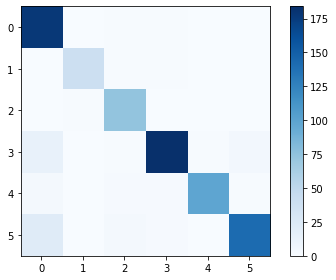

In [109]:
train_model(X_train, y_train, X_test, y_test, 0.001, 50, 256)